# Supplemental Figure S8: Median CV ratio (WC/Non-WC) for different data groupings

# Setup

## imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from dms_3d_features.plotting import *

## extra functions

In [20]:
def bootstrap_ratio(df, group_name, n_boot=5000):
    wc = df.query("r_type == 'Flank-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values
    non_wc = df.query("r_type == 'NON-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values

    ratios = []
    for _ in tqdm(range(n_boot)):
        wc_sample = np.random.choice(wc, size=len(wc), replace=True)
        non_wc_sample = np.random.choice(non_wc, size=len(non_wc), replace=True)
        ratio = np.median(wc_sample) / np.median(non_wc_sample)
        ratios.append(ratio)

    return np.array(ratios)

## load data

In [21]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

# Plotting

In [33]:
# Group the data and calculate statistics
df_fig_1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_fig_1 = df_fig_1.query("r_data_outlier == False").copy()
df_second_stack = (
    df_fig_1.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

In [34]:
df_sub = pd.read_csv(f"{REVISION_PATH}/cv_csvs/randomized_cvs.csv")

In [35]:
df_cv = (
    df_fig_1.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "None"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_sub["data_type"] = "Random"
df_all = pd.concat([df_second_stack_cv, df_cv, df_sub]).reset_index(drop=True)

In [36]:
# Create median dataframe
median_df = (
    df_all.groupby(["r_type", "data_type"])["cv_r_data"]
    .median()
    .reset_index()
    .rename(columns={"cv_r_data": "median_cv"})
)
print(median_df)

     r_type     data_type  median_cv
0  Flank-WC          None   0.412337
1  Flank-WC        Random   0.360719
2  Flank-WC  Second Stack   0.323507
3    NON-WC          None   0.281566
4    NON-WC        Random   0.252336
5    NON-WC  Second Stack   0.208480
6        WC          None   0.419006
7        WC  Second Stack   0.389617


In [37]:
# Calculate WC / NON-WC median CV ratios for each data_type
ratios = (
    median_df.pivot(index="data_type", columns="r_type", values="median_cv")
    .reset_index()
    .assign(median_ratio_WC_vs_NON_WC=lambda d: d["Flank-WC"] / d["NON-WC"])
)
print("Median CV ratios (WC / NON-WC):")
print(ratios[["data_type", "median_ratio_WC_vs_NON_WC"]])

Median CV ratios (WC / NON-WC):
r_type     data_type  median_ratio_WC_vs_NON_WC
0               None                   1.464442
1             Random                   1.429521
2       Second Stack                   1.551738


In [38]:
df_all["data_type"].unique()

array(['Second Stack', 'None', 'Random'], dtype=object)

In [39]:
# Bootstrap for Random and Second Stack
ratios_random = bootstrap_ratio(df_all, "Random")
ratios_stack = bootstrap_ratio(df_all, "Second Stack")
ratios_none = bootstrap_ratio(df_all, "None")

# Compare to the baseline value from "None"
baseline_ratio = 1.464442

# 95% confidence intervals
ci_random = np.percentile(ratios_random, [0.5, 99.5])
ci_stack = np.percentile(ratios_stack, [0.5, 99.5])

print(
    f"Random 99% CI: {ci_random}, contains baseline? {ci_random[0] <= baseline_ratio <= ci_random[1]}"
)
print(
    f"Second Stack 99% CI: {ci_stack}, contains baseline? {ci_stack[0] <= baseline_ratio <= ci_stack[1]}"
)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 8286.86it/s]

Random 99% CI: [1.40785462 1.45197693], contains baseline? False
Second Stack 99% CI: [1.52474798 1.58052208], contains baseline? False


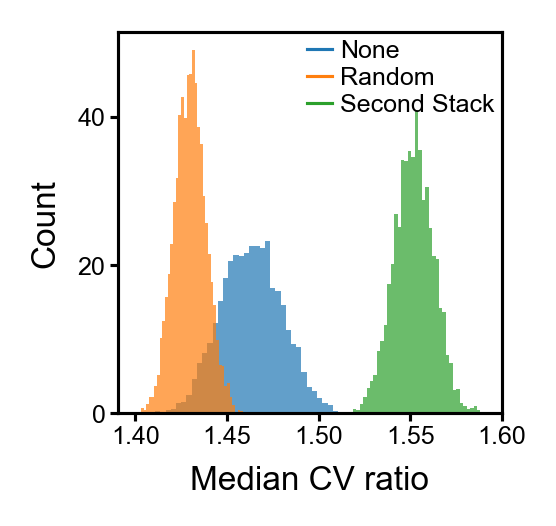

In [40]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=300)

ax.hist(
    ratios_none,
    bins=40,
    alpha=0.7,
    label="None",
    density=True,
    color="tab:blue",
)
ax.hist(
    ratios_random, bins=40, alpha=0.7, label="Random", density=True, color="tab:orange"
)
ax.hist(
    ratios_stack,
    bins=40,
    alpha=0.7,
    label="Second Stack",
    density=True,
    color="tab:green",
)

ax.set_xlabel("Median CV ratio")
ax.set_ylabel("Count")
ax.set_xticks([1.40, 1.45, 1.50, 1.55, 1.60])
add_legend(ax, ["None", "Random", "Second Stack"])

publication_style_ax(ax)
fig.savefig("../../figures/supplemental_figures/supplemental_figure_s8.png", dpi=300, bbox_inches="tight")